In [62]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [63]:
fname = '/net/jam-amaro-shared/dse_project/Spike_Dataset/TRAJECTORIES_spike_open_prot_glyc_amarolab/results/FinalExtractedFeature_open.csv'
open_df = pd.read_csv(fname).assign(label = 1).iloc[:,1:]

In [64]:
print(f'open dcd size : {open_df.shape}')
open_df.head()

open dcd size : (42222, 221)


,Frame Num,frame,RBD_CA0:ROF,RBD_CA0:RMSD,RBD__2__CH_CA0,CH_CA0:ROF,CH_CA0:RMSD,RBD__2__GLY0,GLY0:ROF,GLY0:RMSD,...,RBD__2__GLY8,GLY8:ROF,GLY8:RMSD,RBD__2__GLY9,GLY9:ROF,GLY9:RMSD,RBD__2__backbone0,backbone0:ROF,backbone0:RMSD,label
0,0,frame_0,2.146310,0.135435,8.696114,2.430049,0.073119,6.597967,1.519505,0.309062,...,17.516027,2.425352,0.294207,20.553479,1.791446,0.278311,7.953154,7.455652,0.138682,1
1,1,frame_1,2.141260,0.170498,8.610321,2.452126,0.070816,6.323298,1.377560,0.281506,...,17.493029,2.410283,0.346432,20.551318,1.787035,0.402983,7.894130,7.443351,0.165635,1
2,2,frame_2,2.131270,0.153697,8.592710,2.430950,0.079461,6.274642,1.494150,0.237929,...,17.299496,2.297616,0.433491,20.409004,1.919100,0.455504,7.841270,7.439311,0.179153,1
3,3,frame_3,2.126830,0.181805,8.590594,2.439935,0.073912,6.287297,1.520262,0.246225,...,17.104382,2.345125,0.363078,20.299202,1.932984,0.360417,7.843353,7.431243,0.204023,1
4,4,frame_4,2.132262,0.173935,8.585232,2.446247,0.075612,6.173709,1.459852,0.213698,...,17.266876,2.344855,0.299472,20.380623,1.847637,0.358222,7.848105,7.426812,0.220511,1


In [65]:
def restrict_RBD_window(df,nm):
    '''Function to drop features of dataframe that correspond to glycans which are outside a given RBD neighborhood (in nm)'''
    #Get list of glycans
    glycans = list(np.unique([x.replace('RBD__2__','') for x in df.keys().to_list() if 'RBD__2__GLY' in x]))
    
    for g in glycans:
        if df['RBD__2__' + g].mean() > nm:
            df.drop(['RBD__2__'+g,g+':ROF',g+':RMSD'],axis=1,inplace=True)
            
    return df
    #for each glycan, if avg RBD__2__GLY distance > nm, drop that feature and other related features

In [66]:
fname = '/net/jam-amaro-shared/dse_project/Spike_Dataset/TRAJECTORIES_spike_closed_prot_glyc_amarolab/results/FinalExtractedFeature_closed.csv'
closed_df = pd.read_csv(fname).assign(label = 0).iloc[:,1:]

In [67]:
print(f'closed dcd size : {closed_df.shape}')
closed_df.head()

closed dcd size : (17314, 221)


,Frame Num,frame,RBD_CA0:ROF,RBD_CA0:RMSD,RBD__2__CH_CA0,CH_CA0:ROF,CH_CA0:RMSD,RBD__2__GLY0,GLY0:ROF,GLY0:RMSD,...,RBD__2__GLY8,GLY8:ROF,GLY8:RMSD,RBD__2__GLY9,GLY9:ROF,GLY9:RMSD,RBD__2__backbone0,backbone0:ROF,backbone0:RMSD,label
0,0,frame_0,2.064992,0.104537,7.011860,2.440622,0.071946,8.272009,1.753118,0.256231,...,15.816480,2.131665,0.296665,18.712970,2.230321,0.390132,6.132472,7.333359,0.137631,0
1,1,frame_1,2.082220,0.142265,7.059966,2.451281,0.067347,8.274339,1.777587,0.298775,...,15.865187,2.082916,0.267647,18.565217,2.212942,0.319875,6.172430,7.338856,0.161682,0
2,2,frame_2,2.079883,0.168931,7.061981,2.428138,0.075575,8.126430,1.926069,0.304831,...,15.789881,2.140586,0.278618,18.491900,2.070410,0.297723,6.154211,7.331262,0.173915,0
3,3,frame_3,2.105020,0.156687,7.035488,2.423324,0.076875,8.221630,1.901495,0.362107,...,15.844295,2.129400,0.294769,18.489304,2.043514,0.243517,6.143025,7.325061,0.189567,0
4,4,frame_4,2.107028,0.128242,6.968371,2.426547,0.086771,8.170091,1.940600,0.308735,...,15.790533,2.163263,0.299083,18.452190,2.221308,0.352847,6.106590,7.313821,0.198229,0


In [93]:
# Only use glycans within 10 nm of the RBD
open_df = restrict_RBD_window(open_df,8)
closed_df = restrict_RBD_window(closed_df,8)


In [94]:
common_cols = set(open_df.columns.to_list()).intersection(closed_df.columns.to_list())
full_df = open_df.loc[:,common_cols].append(closed_df.loc[:,common_cols]).drop(['frame','Frame Num'],axis=1)
full_df.shape

/tmp/ipykernel_8032/2444760398.py:2: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

/tmp/ipykernel_8032/2444760398.py:2: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

/tmp/ipykernel_8032/2444760398.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(59536, 105)

## Looking for Correlations

In [95]:
corr_matrix = full_df.corr()
corr_thresh = 0.5 #original was 0.65
final_features = corr_matrix['RBD_CA0:RMSD'][(corr_matrix['RBD_CA0:RMSD'] < corr_thresh) & (corr_matrix['RBD_CA0:RMSD'] > -corr_thresh)].reset_index().loc[:,'index'].to_list()
clf_df = full_df.loc[:,final_features]

In [96]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(clf_df,test_size=0.3, random_state=42,stratify=full_df.label)
print(f'Train set : {train_set.shape}, Test set : {test_set.shape}')

Train set : (41675, 97), Test set : (17861, 97)


In [106]:
# List glycans included
list(np.unique([x.replace('RBD__2__','') for x in train_set.keys().to_list() if 'RBD__2__GLY' in x]))

['GLY0',
 'GLY1',
 'GLY11',
 'GLY12',
 'GLY13',
 'GLY14',
 'GLY15',
 'GLY2',
 'GLY22',
 'GLY23',
 'GLY24',
 'GLY25',
 'GLY26',
 'GLY3',
 'GLY32',
 'GLY35',
 'GLY37',
 'GLY4',
 'GLY42',
 'GLY43',
 'GLY44',
 'GLY48',
 'GLY49',
 'GLY5',
 'GLY50',
 'GLY51',
 'GLY55',
 'GLY56',
 'GLY57',
 'GLY66',
 'GLY67',
 'GLY69']

# Prepare the Data for Machine Learning Algorithms

In [107]:
import plotly.express as px
import time

In [98]:
train_X = train_set.drop("label", axis=1) # drop labels for training set
train_labels = train_set["label"].copy()
train_X.shape,train_labels.shape

((41675, 96), (41675,))

In [99]:
test_X = test_set.drop("label", axis=1) # drop labels for training set
test_labels = test_set["label"].copy()
test_X.shape, test_labels.shape

((17861, 96), (17861,))

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
       ('std_scaler', StandardScaler()),
    ])

train_X_prepared = num_pipeline.fit_transform(train_X)
test_X_prepared = num_pipeline.transform(test_X)

In [101]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=100, tol=1e-3, random_state=42)

In [109]:
from sklearn.model_selection import cross_val_score,cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,train_X_prepared, train_labels, cv=10)
t = time.time()
cross_val_score(sgd_clf, train_X_prepared, train_labels, cv=10, scoring="accuracy")
print(str(time.time()-t) + ' sec elapsed')

1.21116042137146 sec elapsed


## Precision and Recall

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
confusion_matrix(train_labels, y_train_pred)
print(f' Train precison : {precision_score(train_labels, y_train_pred)}, train recall {recall_score(train_labels, y_train_pred)}')

 Train precison : 1.0, train recall 1.0


In [104]:
sgd_clf.fit(train_X_prepared,train_labels)
y_test_pred = sgd_clf.predict(test_X_prepared)
print(f' Test precison : {precision_score(test_labels, y_test_pred)}, Test recall {recall_score(test_labels, y_test_pred)}')
px.bar(x=train_X.columns.to_list(),y=sgd_clf.coef_[0],color=sgd_clf.coef_[0]).update_xaxes(categoryorder='total ascending')

 Test precison : 1.0, Test recall 1.0


In [92]:
sgd_clf.coef_[0][train_X.columns.to_list().index('RBD__2__GLY40')]

0.3505202334708687

In [18]:
train_X.columns.to_list().index('RBD__2__backbone0')

53

In [121]:
train_X.keys()

Index(['GLY25:ROF', 'RBD__2__GLY13', 'GLY22:ROF', 'RBD__2__GLY69',
       'RBD__2__GLY48', 'RBD__2__GLY23', 'GLY15:RMSD', 'GLY43:ROF',
       'RBD__2__GLY2', 'GLY22:RMSD', 'RBD__2__GLY55', 'RBD__2__GLY57',
       'GLY11:RMSD', 'RBD__2__GLY43', 'GLY24:RMSD', 'RBD__2__GLY51',
       'GLY66:ROF', 'RBD__2__GLY44', 'RBD__2__GLY35', 'RBD__2__GLY15',
       'CH_CA0:RMSD', 'RBD__2__GLY67', 'GLY15:ROF', 'GLY5:ROF',
       'backbone0:RMSD', 'RBD__2__backbone0', 'CH_CA0:ROF', 'RBD__2__GLY25',
       'RBD__2__GLY42', 'GLY23:RMSD', 'GLY26:ROF', 'RBD__2__GLY26',
       'GLY51:RMSD', 'GLY14:ROF', 'GLY67:ROF', 'GLY55:ROF', 'RBD__2__GLY14',
       'RBD__2__GLY11', 'RBD__2__GLY56', 'backbone0:ROF', 'RBD__2__GLY50',
       'RBD__2__GLY0', 'RBD__2__GLY12', 'GLY25:RMSD', 'GLY42:RMSD',
       'GLY32:ROF', 'GLY23:ROF', 'GLY13:RMSD', 'RBD__2__GLY24',
       'RBD__2__CH_CA0', 'GLY14:RMSD', 'GLY55:RMSD', 'GLY24:ROF', 'GLY48:RMSD',
       'RBD__2__GLY49', 'RBD__2__GLY66', 'GLY13:ROF', 'GLY1:ROF', 'GLY4:ROF',
   

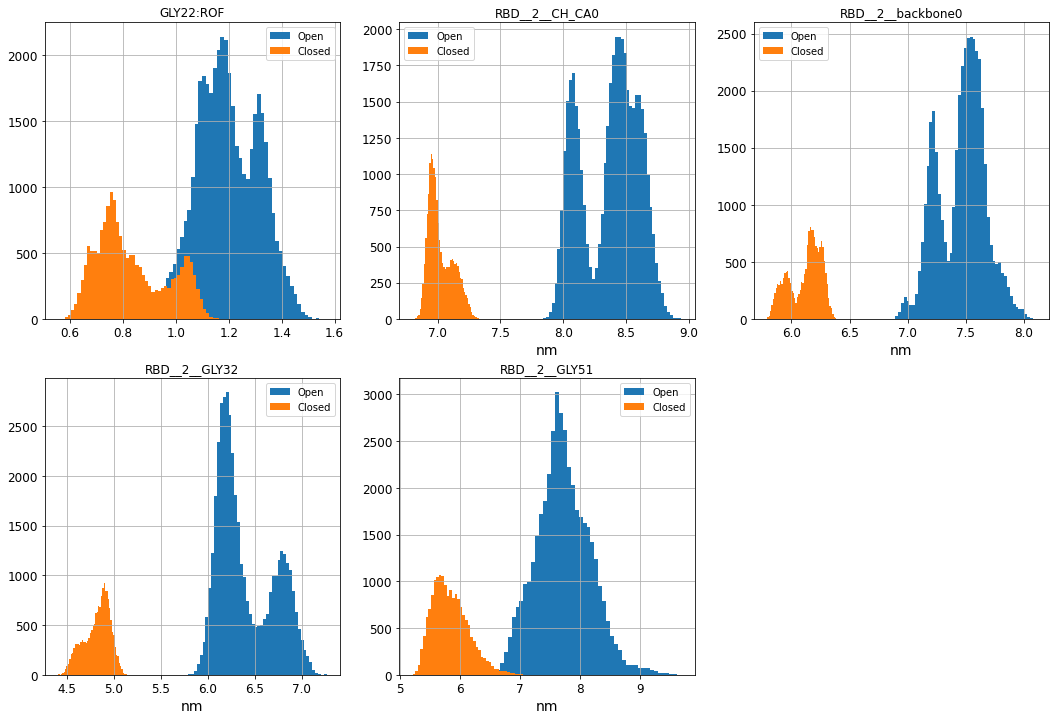

In [148]:
import matplotlib.pyplot as plt

feat = 'RBD__2__GLY51'
def overlapping_hist(open_df,closed_df,feat):
    open_df[feat].hist(bins=50)
    closed_df[feat].hist(bins=50)
    plt.legend(['Open','Closed'])
    plt.title(feat)
    if 'RBD__2__' in feat:
        plt.xlabel('nm')
    
feats = ['GLY22:ROF','RBD__2__CH_CA0','RBD__2__backbone0','RBD__2__GLY32','RBD__2__GLY51']
plt.figure(figsize=(18,12))
for i in range(len(feats)):
    plt.subplot(2,3,i+1)
    overlapping_hist(open_df,closed_df,feats[i])

array([[<AxesSubplot:title={'center':'GLY25:ROF'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY13'}>,
        <AxesSubplot:title={'center':'GLY22:ROF'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY69'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY48'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY23'}>,
        <AxesSubplot:title={'center':'GLY15:RMSD'}>,
        <AxesSubplot:title={'center':'GLY43:ROF'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY2'}>,
        <AxesSubplot:title={'center':'GLY22:RMSD'}>],
       [<AxesSubplot:title={'center':'RBD__2__GLY55'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY57'}>,
        <AxesSubplot:title={'center':'GLY11:RMSD'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY43'}>,
        <AxesSubplot:title={'center':'GLY24:RMSD'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY51'}>,
        <AxesSubplot:title={'center':'GLY66:ROF'}>,
        <AxesSubplot:title={'center':'RBD__2__GLY44'}>,
        <AxesSubplot

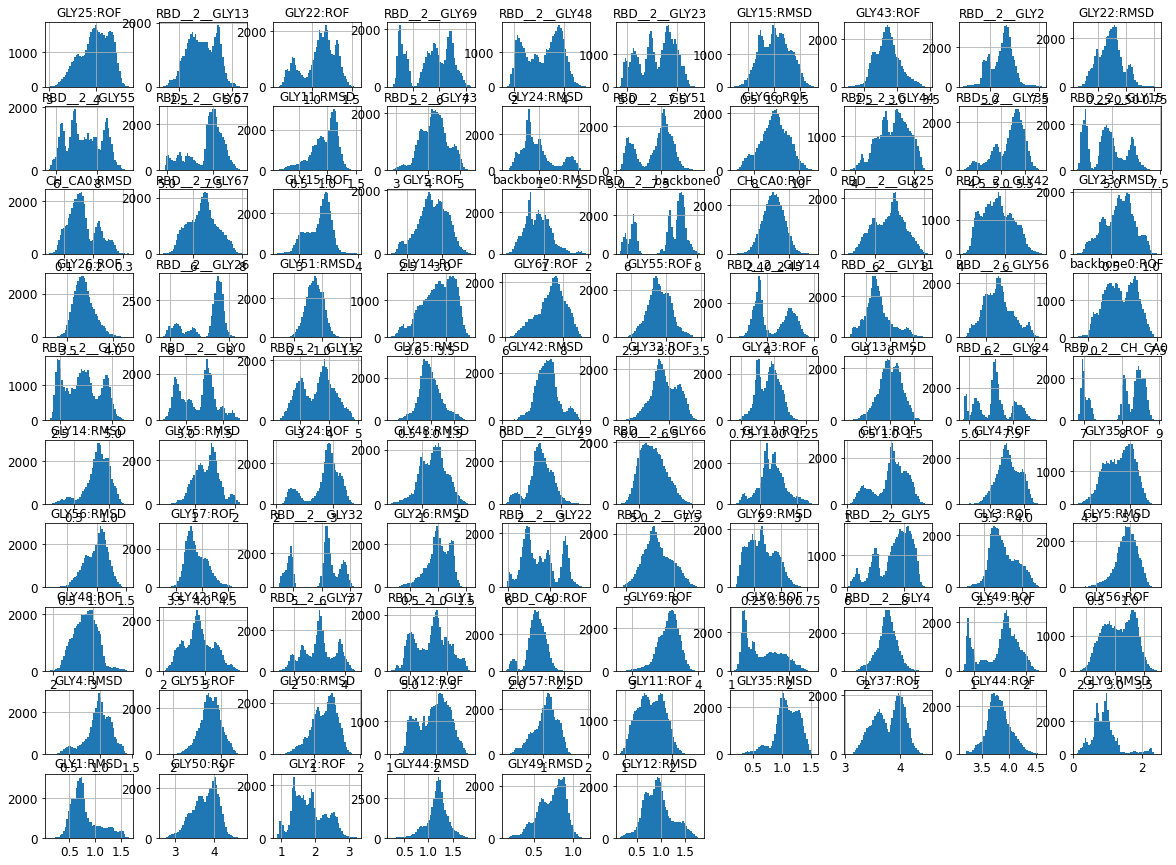

In [110]:
train_X.hist(bins=50, figsize=(20,15))